# Speed it up! Part II

In [1]:
import math
import random
import numpy as np
import numba
#import dask.array as da
#from joblib import Parallel, delayed
from matplotlib import pyplot as plt

---
# Compile it with Numba!
One of my favorite Python libraries is `Numba`. If `Numpy` or other greate libraries still don't offer the right functions for your problem, than this is the perfect way to build very performant functions yourself (without any need to switch to C/C++ or other languages).

### Compiling modes
Numba offers several compilation modes. Typically we will work with
- `nopython = True` which will raise an error if compilation in the fast "nopython mode" won't work
- `nogil = True` which can be used to avoid the restrictions of the GIL (global interpreter lock), but also requires a better understanding of what this means...
- `parallel = True` which enabels automatic parallelization (we will see more on this in a bit).

See also [Numba documentation on compiling options](https://numba.readthedocs.io/en/stable/user/jit.html).

Or the [Numba 5 minutes guide](https://numba.pydata.org/numba-doc/latest/user/5minguide.html).

### Reminder: last weeks options were Python vs. Numpy (vs. dask)

In [2]:
%timeit sum(range(10**7))

247 ms ± 34.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
def sum_range(N):
    """Compute the sum of the numbers in the range [0, N)."""
    total = 0
    for i in range(N):
        total += i
    return total

In [5]:
%timeit sum_range(10**7)

360 ms ± 29.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Numpy version:

In [6]:
import numpy as np

%timeit np.arange(10**7).sum()

14.8 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Numba version:
In this example, numba has a couple of advantages.
First, it does not require to rethink the problem to convert it into a vectorized (*or numpy-fied*) version. This does not always work, but here it will.

Second, the numpy solution is not very elegant here and has a huge downside: it requires writing a full array of all numbers from $0$ to $10^7$ to memory, while the Python (and the numba) version only keep track of the one value stored in `total`.

In [7]:
import numba

@numba.jit(nopython=True)
def sum_range_numba(N):
    """Compute the sum of the numbers in the range [0, N)."""
    total = 0
    for i in range(N):
        total += i
    return total

In [8]:
%timeit sum_range_numba(10**7)

The slowest run took 48.50 times longer than the fastest. This could mean that an intermediate result is being cached.
1.67 µs ± 3.28 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# second run:
%timeit sum_range_numba(10**7)

118 ns ± 15.6 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [15]:
%%time
sum_range_numba(1e9)

CPU times: total: 0 ns
Wall time: 0 ns


499999999500000000

## Wow! Does this always do the trick?
Sadly: no.

Numba compiles the code and this means we loose some aspects of what Python code can do.
With compiling, something that is not really important in Python suddently becomes very important: **the data type**.

Numba works best with Numpy data types and functions as well as basic Python data types and code.
In general Numba supports the following:
- Windows (32 and 64 bit), OSX and Linux (32 and 64 bit)
- Architectures: x86, x86_64, ppc64le. Experimental on armv7l, armv8l (aarch64).
- GPUs: Nvidia CUDA. Experimental on AMD ROC.
- CPython (hence no Jython or others)
- NumPy >= 1.15


In [16]:
import pandas as pd

df = pd.DataFrame({"A": [2, 3, 4, 5],
                   "B": [0, -1, 0, -5],
                  })

@numba.jit(nopython=True)
def get_max(df):
    return df.max()

get_max(df)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at C:\Users\flori\AppData\Local\Temp\ipykernel_35104\1526091316.py (7)[0m
[1m
File "..\..\..\..\..\Users\flori\AppData\Local\Temp\ipykernel_35104\1526091316.py", line 7:[0m
[1m<source missing, REPL/exec in use?>[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'pandas.core.frame.DataFrame'>[0m


In [17]:
@numba.jit(nopython=True)
def do_python_stuff():
    x = [5, 6]
    x.append(2)
    return x

do_python_stuff()

[5, 6, 2]

In [21]:
@numba.jit(nopython=True)
def do_python_stuff():
    x = [5, 6]
    x.append("seven")
    return x

do_python_stuff()

[5, 6, 'seven']

## Use case: simulation (diffusion process)
A diffusion process in form of Brownian motion can be simulated by small random changes to the position of all particles.
This requires updating the position of *every particle* a tiny bit for *many time steps* in a row. This makes it compute-intensive.

In [22]:
import random

# Initialize particles
n_particles = 1000
particles_x = [random.uniform(-1, 1) for _ in range(n_particles)]
particles_y = [random.uniform(-1, 1) for _ in range(n_particles)]

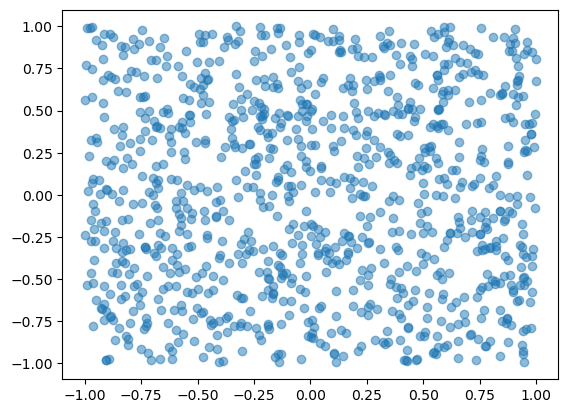

In [25]:
plt.scatter(particles_x, particles_y, alpha=0.5)

In [27]:
[random.gauss(0, 0.1) for _ in range(10)]

[-0.0966928558832502,
 -0.05266056667063153,
 0.014462821284259873,
 -0.0803017016266245,
 0.022035537129963083,
 0.015647713898649645,
 0.03557069739491065,
 -0.01905197521789405,
 0.15577332118291057,
 0.033316094105022086]

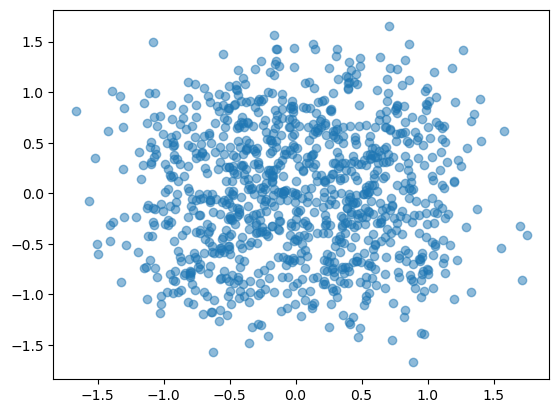

In [29]:
plt.scatter(x, y, alpha=0.5)

In [28]:
def diffusion_python(particles_x, particles_y, n_timesteps):
    for _ in range(n_timesteps):
        particles_x = [x + random.gauss(0, 0.1) for x in particles_x]
        particles_y = [y + random.gauss(0, 0.1) for y in particles_y]

    return particles_x, particles_y

x, y = diffusion_python(particles_x, particles_y, 10)

## Check runtime:

In [52]:
%%time
# Initialize particles
n_particles = 10000
particles_x = [random.uniform(-1, 1) for _ in range(n_particles)]
particles_y = [random.uniform(-1, 1) for _ in range(n_particles)]

x, y = diffusion_python(particles_x, particles_y, 200)

CPU times: total: 391 ms
Wall time: 2.44 s


## Numba-fy your code!
Now, please try to convert the `diffusion_python` function to a just-in-time compiled `diffusion_numba` function.

Try by simply using the `@numba.jit(nopython=True)` decorator.

In [32]:
@numba.jit(nopython=True)
def diffusion_numba(particles_x, particles_y, n_timesteps):
    for _ in range(n_timesteps):
        particles_x = [x + random.gauss(0, 0.1) for x in particles_x]
        particles_y = [y + random.gauss(0, 0.1) for y in particles_y]

    return particles_x, particles_y

In [40]:
%%time

# Initialize particles
particles_x = [random.uniform(-1, 1) for _ in range(n_particles)]
particles_y = [random.uniform(-1, 1) for _ in range(n_particles)]

x, y = diffusion_numba(particles_x, particles_y, 200)

CPU times: total: 46.9 ms
Wall time: 141 ms


## Numpy-fy your code!

In [37]:
import numpy as np

def diffusion_numpy(particles, n_timesteps):
    for _ in range(n_timesteps):
        particles += np.random.randn(particles.shape[0], particles.shape[1])

    return particles

In [41]:
%%time
# Initialize particles
n_particles = 10000
particles = np.random.uniform(-1, 1, size=(n_particles, 2))

particles = diffusion_numpy(particles, 200)

CPU times: total: 31.2 ms
Wall time: 97.4 ms


In [44]:
particles.shape

(10000, 2)

## Try to parallelize

"Embarassingly parallel" --> `range` --> `prange`

In [ ]:
@numba.jit(nopython=True, parallel=True)
def diffusion_numba_parallel(n_particles, n_timesteps):
    # Initialize particles
    particles = [[random.uniform(-1, 1), random.uniform(-1, 1)] for _ in range(n_particles)]

    for i, particle in enumerate(particles):
        for _ in numba.prange(n_timesteps):
            particles[i] = [particle[0] + random.gauss(0, 0.1), particle[1] + random.gauss(0, 0.1)]

    return particles

In [ ]:
# Will kill kernel!
%%time
particles = diffusion_numba_parallel(10000, 200)

In [45]:
import numba
import numpy as np
from numba import prange

@numba.jit(nopython=True, parallel=True)
def diffusion_numba_parallel(n_particles, n_timesteps):
    # Initialize particles using a NumPy array
    particles = np.random.uniform(-1, 1, (n_particles, 2))

    for i in prange(n_particles):
        for t in range(n_timesteps):
            dx = np.random.normal(0, 0.1)
            dy = np.random.normal(0, 0.1)
            particles[i, 0] += dx
            particles[i, 1] += dy

    return particles

In [51]:
%%time
particles = diffusion_numba_parallel(10000, 200)

CPU times: total: 15.6 ms
Wall time: 12.1 ms


## Visualization with VisPy

Install VisPy with `pip install vispy`.

In [ ]:
#!pip install vispy

In [53]:
%gui qt

In [58]:
@numba.jit(nopython=True)
def diffusion(particles_x, particles_y, n_timesteps=1):
    for _ in range(n_timesteps):
        particles_x = [x + random.gauss(0, 0.1) for x in particles_x]
        particles_y = [y + random.gauss(0, 0.1) for y in particles_y]

    return particles_x, particles_y

In [60]:
import random
import numpy as np
from vispy import scene
from vispy.app import Timer

# Define our points/spheres
n_points = 10000
sizes = 10 * np.ones((n_points))
face_colors = [(1, np.random.random(), np.random.random(), 1) for i in range(n_points)]

# Create a canvas with interactive controls
canvas = scene.SceneCanvas(keys='interactive', show=True)
view = canvas.central_widget.add_view()

# Set up camera
view.camera = 'turntable'
view.camera.fov = 45
view.camera.distance = 50

# Generate initial random coordinates for points
x = np.random.normal(size=(n_points), scale=10)
y = np.random.normal(size=(n_points), scale=10)

# Create a scatter plot
scatter = scene.visuals.Markers()
scatter.set_data(np.array([x, y]).T, edge_color=None, face_color=face_colors, size=sizes)
view.add(scatter)

# Diffusion loop
def diffusion_step(event):
    global x, y
  
    # Update points positions
    x, y = diffusion(x, y, 10)
    scatter.set_data(np.array([x, y]).T, edge_color=None, face_color=face_colors, size=sizes)

# Create a timer to update the plot
timer = Timer(interval=0.05, connect=diffusion_step, start=True)

  File "C:\Users\flori\anaconda3\envs\python_software_dev\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\flori\anaconda3\envs\python_software_dev\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\flori\anaconda3\envs\python_software_dev\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\flori\anaconda3\envs\python_software_dev\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\flori\anaconda3\envs\python_software_dev\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
    self.io_loop.start()
  File "C:\Users\flori\anaconda3\envs\python_software_dev\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\flori\anaconda3\envs\python_software_dev\lib\asyncio\base_events.py", line 603, in run_forever


## If time --> add rigid-body repulsion (kind of)
So far, the particles can take any position and can overlap in any way.
To make the particle motion look at least a bit more realistic, we can introduce some sort of repulsion between particles.

In [61]:
import random
import math
import numba
import numpy as np

def distance(p1, p2):
    """Compute distance between p1 and p2."""
    return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def add_noise(x, y, sigma=0.01):
    """Add normal distributed noise to x and y."""
    return (x + random.gauss(0, sigma), y + random.gauss(0, sigma))

def apply_repulsion(p1, p2, d=0.2):
    dist = distance(p1, p2)
    # Add repulsion if to elements are closer than 2x their radius
    if dist < d:
        force = d - dist
        angle = math.atan2(p1[1] - p2[1], p1[0] - p2[0])
        return (p1[0] + force * math.cos(angle), p1[1] + force * math.sin(angle))
    return p1

def diffusion_step(particles):
    return [add_noise(p[0], p[1]) for p in particles]

def repulsion_step(particles, d, max_motion):
    for i in range(n):
        for j in range(i + 1, n):
            particles[i] = apply_repulsion(particles[i], particles[j], d)
            particles[j] = apply_repulsion(particles[j], particles[i], d)
    return particles

In [63]:
%%time
n = 1000
radius = 1
particles = [(random.uniform(-radius, radius), random.uniform(-radius, radius)) for _ in range(n)]

for _ in range(1):
    particles = diffusion_step(particles)
    particles = repulsion_step(particles, 0.2, 0.1)

CPU times: total: 297 ms
Wall time: 927 ms


## Create a visualization of this process

In [68]:
import random
import numpy as np
from vispy import app, scene
from vispy.app import Timer

n = 500  # Number of particles
d = 0.5  # Size of each particle
radius = 1  # Radius of the starting sphere

# Create a canvas with interactive controls
canvas = scene.SceneCanvas(keys='interactive', show=True)
view = canvas.central_widget.add_view()

# Set up camera
view.camera = 'turntable'
view.camera.fov = 45
view.camera.distance = 50

# Initialize particles
particles = [(random.uniform(-radius, radius), random.uniform(-radius, radius)) for _ in range(n)]
sizes = 25 * np.ones(n)

# Create a scatter plot
scatter = scene.visuals.Markers()
scatter.set_data(np.array(particles), edge_color=None, size=sizes) #, face_color=face_colors, size=sizes) #(1, 1, 1, 1), size=5)
view.add(scatter)

# Diffusion loop
def particle_motion(event):
    global particles
    
    # Apply Brownian motion
    particles = diffusion_step(particles)

    # Apply repulsion
    particles = repulsion_step(particles, d, 0.1)
    scatter.set_data(np.array(particles), edge_color=None, size=sizes)

# Create a timer to update the plot
timer = Timer(interval=0.05, connect=particle_motion, start=True)

ERROR: Invoking <function diffusion_step at 0x0000017731825FC0> repeat 2048
ERROR: Invoking <function diffusion_step at 0x000001772DBDB760> repeat 2048
ERROR: Invoking <function diffusion_step at 0x0000017731825FC0> repeat 4096
ERROR: Invoking <function diffusion_step at 0x000001772DBDB760> repeat 4096
ERROR: Invoking <function diffusion_step at 0x0000017731825FC0> repeat 8192
ERROR: Invoking <function diffusion_step at 0x000001772DBDB760> repeat 8192
ERROR: Invoking <function diffusion_step at 0x0000017731825FC0> repeat 16384
ERROR: Invoking <function diffusion_step at 0x000001772DBDB760> repeat 16384
ERROR: Invoking <function diffusion_step at 0x0000017731825FC0> repeat 32768
ERROR: Invoking <function diffusion_step at 0x000001772DBDB760> repeat 32768


In [65]:
from vispy import scene
from vispy.app import Timer

# Define our points/spheres
n_points = 100
sizes = 10 * np.ones((n_points))
face_colors = [(1, np.random.random(), np.random.random(), 1) for i in range(n_points)]

# Create a canvas with interactive controls
canvas = scene.SceneCanvas(keys='interactive', show=True)
view = canvas.central_widget.add_view()

# Set up camera
view.camera = 'turntable'
view.camera.fov = 45
view.camera.distance = 50

# Generate initial random coordinates for points
particles = [(random.uniform(-radius, radius), random.uniform(-radius, radius)) for _ in range(n_points)]

# Create a scatter plot
scatter = scene.visuals.Markers()
scatter.set_data(np.array(particles).T, edge_color=None, face_color=face_colors, size=sizes)
view.add(scatter)

# Diffusion loop
def diffusion_step(event):
    global particles
    
    particles = diffusion_step(particles)
    particles = repulsion_step(particles, 0.2, 0.1)
    scatter.set_data(np.array(particles).T, edge_color=None, face_color=face_colors, size=sizes)

# Create a timer to update the plot
timer = Timer(interval=0.05, connect=diffusion_step, start=True)

AssertionError: 

ERROR: Invoking <function diffusion_step at 0x0000017731825FC0> repeat 512
ERROR: Invoking <function diffusion_step at 0x000001772DBDB760> repeat 512
